# Define $\phi_\pi$ acceptance correction based on SIDIS data from run 6420

last edit May-4, 2022

## Imports and definitions

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sys; sys.path.insert(0, '/Users/erezcohen/Desktop/Software/mySoftware/Python/'); 
import sys; sys.path.insert(0, '/Users/erezcohen/Desktop/Software/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/AcceptanceCorrections/'); 
from my_tools                     import *; 
from plot_tools                   import *;
from my_data_analysis_tools       import *;
from acceptance_correction_tools  import *;

%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

## Auxiliary functions

# (1) Load SIDIS data from runs 6420-6426

In [2]:
load_SIDIS_data( Nruns = 4 )

Run number  6420 (1/4 runs)
Loaded 644481 (e,e piplus ) events and  48 (e,e piplus n), events
retained 25 (e,e piplus n), events with Pn > 275 MeV/c
Loaded 274142 (e,e piminus ) events and  7 (e,e piminus n), events
retained 7 (e,e piminus n), events with Pn > 275 MeV/c
Run number  6421 (2/4 runs)
Loaded 632087 (e,e piplus ) events and  35 (e,e piplus n), events
retained 25 (e,e piplus n), events with Pn > 275 MeV/c
Loaded 272140 (e,e piminus ) events and  12 (e,e piminus n), events
retained 9 (e,e piminus n), events with Pn > 275 MeV/c
Run number  6422 (3/4 runs)
Loaded 601973 (e,e piplus ) events and  57 (e,e piplus n), events
retained 46 (e,e piplus n), events with Pn > 275 MeV/c
Loaded 257778 (e,e piminus ) events and  15 (e,e piminus n), events
retained 10 (e,e piminus n), events with Pn > 275 MeV/c
Run number  6426 (4/4 runs)
Loaded 534955 (e,e piplus ) events and  27 (e,e piplus n), events
retained 17 (e,e piplus n), events with Pn > 275 MeV/c
Loaded 229279 (e,e piminus ) events

### (1.1) Apply selection cuts not previously imposed

In [3]:
e_e_pi_pass_cuts, e_e_pi_n_pass_cuts, e_e_pi_GEMC_pass_cuts = apply_further_selection_cuts_to_data(fdebug=2)

(e,e piplus )
2413496 events before cut
6401871 events after p-theta cut (265.3 %)
5890258 events after M_X cut (244.1 %)
(e,e piminus )
1033339 events before cut
3861744 events after p-theta cut (373.7 %)
3572242 events after M_X cut (345.7 %)


# (2) Compute the acceptance correction as a function of $\phi$

## (2.1) read "height" of acceptance correction from MC

In [4]:
acc_corr_filename = '/Users/erezcohen/Desktop/data/BAND/AcceptanceCorrection/PhiPlateauHeightAcceptanceCorrection.csv'
acc_correction_df = pd.read_csv(acc_corr_filename)

AccCorrecHeight['piplus']     = acc_correction_df['Height-Correction piplus'][0]
AccCorrecHeight_err['piplus'] = acc_correction_df['Height-Correction err piplus'][0]
AccCorrecHeight['piminus']    = acc_correction_df['Height-Correction piminus'][0]
AccCorrecHeight_err['piminus']= acc_correction_df['Height-Correction err piminus'][0]
AccCorrecHeight

{'piplus': 3.0783306746256374, 'piminus': 3.0783306746256374}

## (2.2) compute acceptance correction based on a single data run

In [34]:


# ------------------------------------------------------------------------------------------------ #
def ComputeAcceptanceCorrectionFromBANDDataRun( run=6422 ):#{
    '''
    last update May-4, 2022
    
    Comments:
    
    Compute the acceptance correction for pi+ and pi- using data from a BAND data run 
  
    input: data run
    
    '''
    global e_e_pi_pass_cuts
    global idx_good_phi, idx_bad_phi
    global fraction_bad_phi
    med_AccCorr_phi, std_AccCorr_phi = dict(),dict()
     
    fig = plt.figure(figsize=(16,6));

    
    for pi_ch,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_labels,pi_colors,[1,2]):#{
        ax = fig.add_subplot(1,2,pi_idx)

        df  = e_e_pi_pass_cuts[pi_ch];
        df = df[df.runnum==run]
        phi = np.array(df.pi_Phi)*r2d
        x,histo,x_err,histo_err = plot_step_hist( x_arr=phi,  bins=phi_bins , label='Data',  
                                                 color='royalblue', 
                                                 do_plot_errorbar=False, density=False, linewidth=3)
        h['data-%d'%run]     = histo
        h_err['data-%d'%run] = histo_err
        
        # compute average "height" of the data in the plateau region
        # here for the "plateau" we take the median and not median - 0.2std, 
        # since the data is much "sharper" than the simulation
        indices_in_plateau = np.where( histo > np.median(histo) - 0.*np.std(histo) )
        mean_in_plateau = np.mean( histo[indices_in_plateau] );
        ax.plot( x , mean_in_plateau*np.ones(len(x)) , '-', color='royalblue',
                label=None , alpha=0.2, linewidth=10)

        
        # move average "height" of the data in the plateau region to average
        mean_in_plateau_corrected = mean_in_plateau * AccCorrecHeight[pi_ch]
        ax.plot( x , mean_in_plateau_corrected*np.ones(len(x)) , '-', color='k',
                label=None , alpha=0.2, linewidth=10)

        
        # compute acceptance ccorrection weight in each \phi bin
        AccCorrec[pi_ch]     = mean_in_plateau_corrected * (1./ h['data-%d'%run])
        AccCorrec_err[pi_ch] = mean_in_plateau_corrected * (h_err['data-%d'%run] / (h['data-%d'%run]*h['data-%d'%run]))
        
        # print(AccCorrec[pi_ch])
        # print(AccCorrec_err[pi_ch])
        
        # omit regions of the sharp drop in efficiency 
        med_AccCorr_phi[pi_ch] = np.median( AccCorrec[pi_ch] )
        std_AccCorr_phi[pi_ch] = np.std   ( AccCorrec[pi_ch] )
        idx_bad_phi[pi_ch]     = np.where ( AccCorrec[pi_ch] > med_AccCorr_phi[pi_ch] + 0.2*std_AccCorr_phi[pi_ch] )
        idx_bad_phi[pi_ch]     = np.array (idx_bad_phi[pi_ch]).flatten()
        
        for i in idx_bad_phi[pi_ch]: 
            AccCorrec[pi_ch][i]     = 0
            AccCorrec_err[pi_ch][i] = 0
            
        fraction_bad_phi[pi_ch] = float(len(idx_bad_phi[pi_ch])) / Nphi_pts
        
        # and account for this fraction as another scalar factor in acceptance correction
        AccCorrec[pi_ch]     = AccCorrec[pi_ch]     / (1 - fraction_bad_phi[pi_ch])
        AccCorrec_err[pi_ch] = AccCorrec_err[pi_ch] / (1 - fraction_bad_phi[pi_ch])
        
        # plot acceptance correction in right-axis
        axR = ax.twinx()
        # axR.errorbar( x , AccCorrec[pi_ch], AccCorrec_err[pi_ch], marker='.', color='salmon', linecolor=None )
        # axR.step( x , AccCorrec[pi_ch], color='salmon')
        
        # indicate "bad" (omitted) regions by shadow
        ymax = 1.*np.max(AccCorrec[pi_ch])        
        for i in idx_bad_phi[pi_ch]:
            phi_min = phi_bins[i]
            phi_max = phi_bins[i+1]
            axR.fill_between( [phi_min,phi_max] , [ymax,ymax] , color='salmon' , alpha=0.2, edgecolor=None )

                    
        # cosmetics
        set_axes(ax, '$\phi$ [deg.]', 'Counts [a.u.]' if pi_idx==1 else '',
                 title="$(e,e'"+pi_label+')$',
                 do_add_grid=True,
                 remove_ticks_y=False,
                 do_add_legend=False if pi_idx==2 else False,
                 xlim=phi_xlim,
                 xticks=phi_xticks)   

        set_axes(axR, '', 'Acceptance correction' if pi_idx==2 else '', remove_ticks_y=True)   

#}
# ------------------------------------------------------------------------------------------------ #





fraction of bad phi:
{'piplus': 0.3333333333333333, 'piminus': 0.35555555555555557}


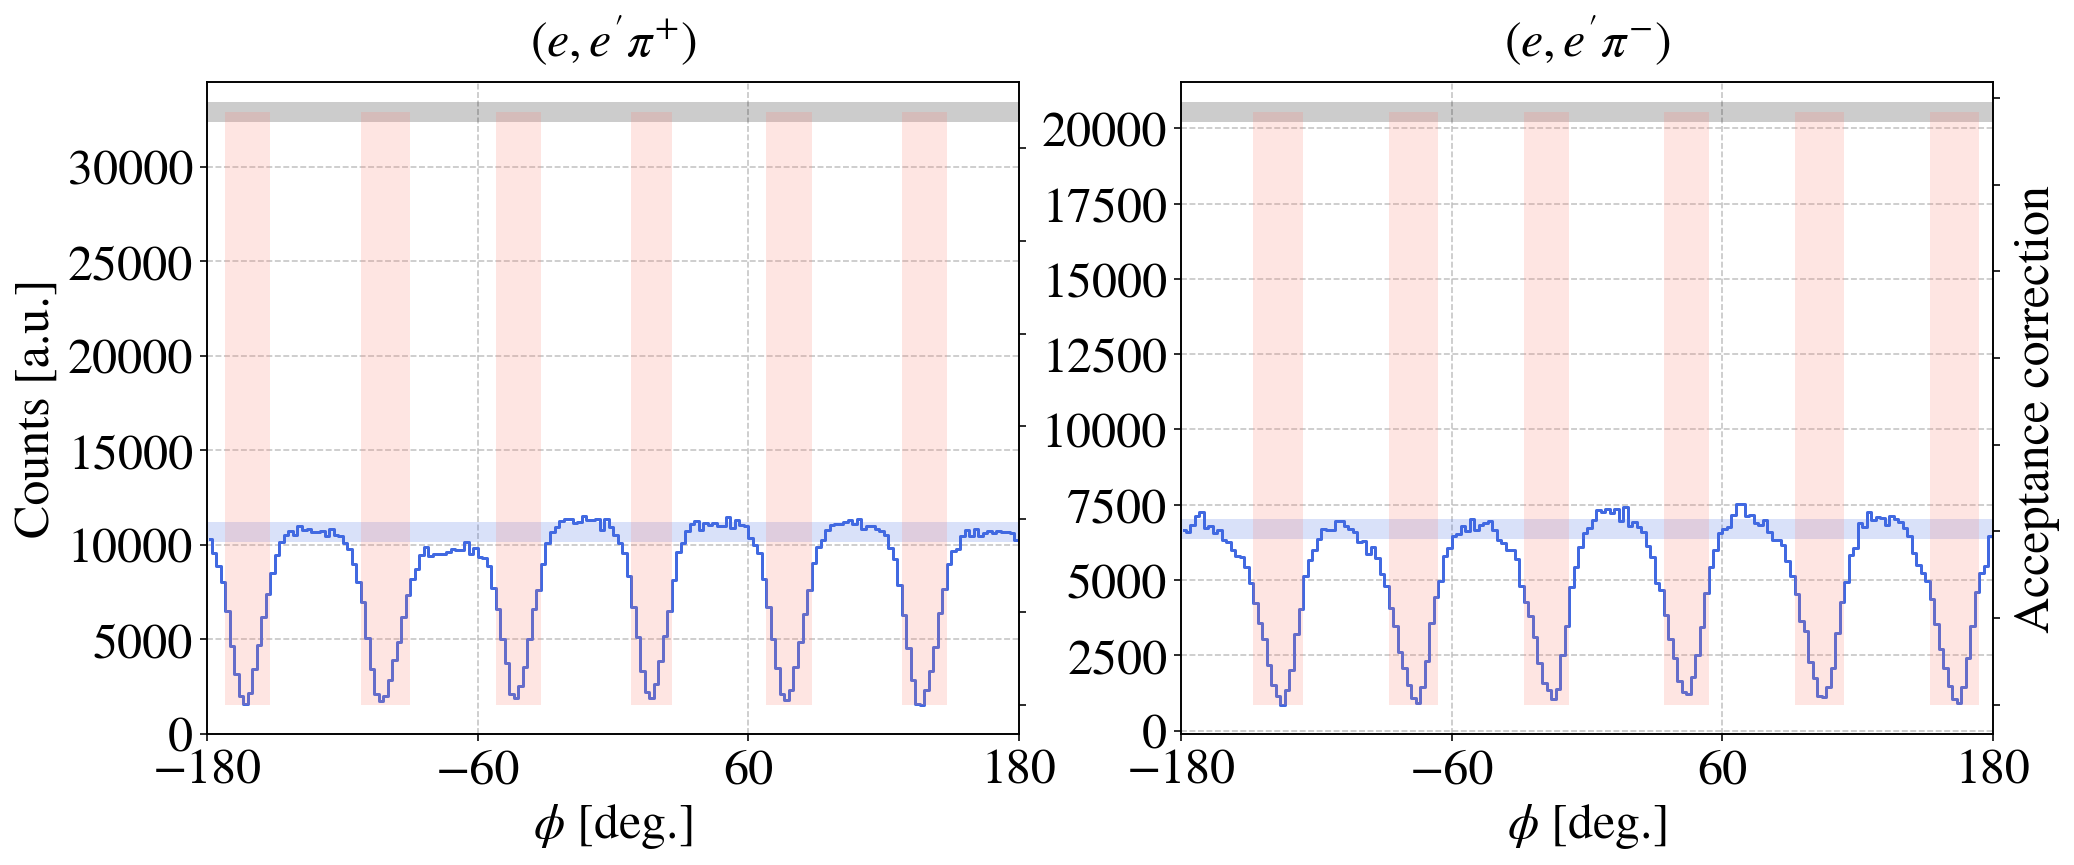

In [35]:
ComputeAcceptanceCorrectionFromBANDDataRun( run=6422 )
print('fraction of bad phi:')
print(fraction_bad_phi)

### Validate: does the correction applied on run 6421 really flatten it? 

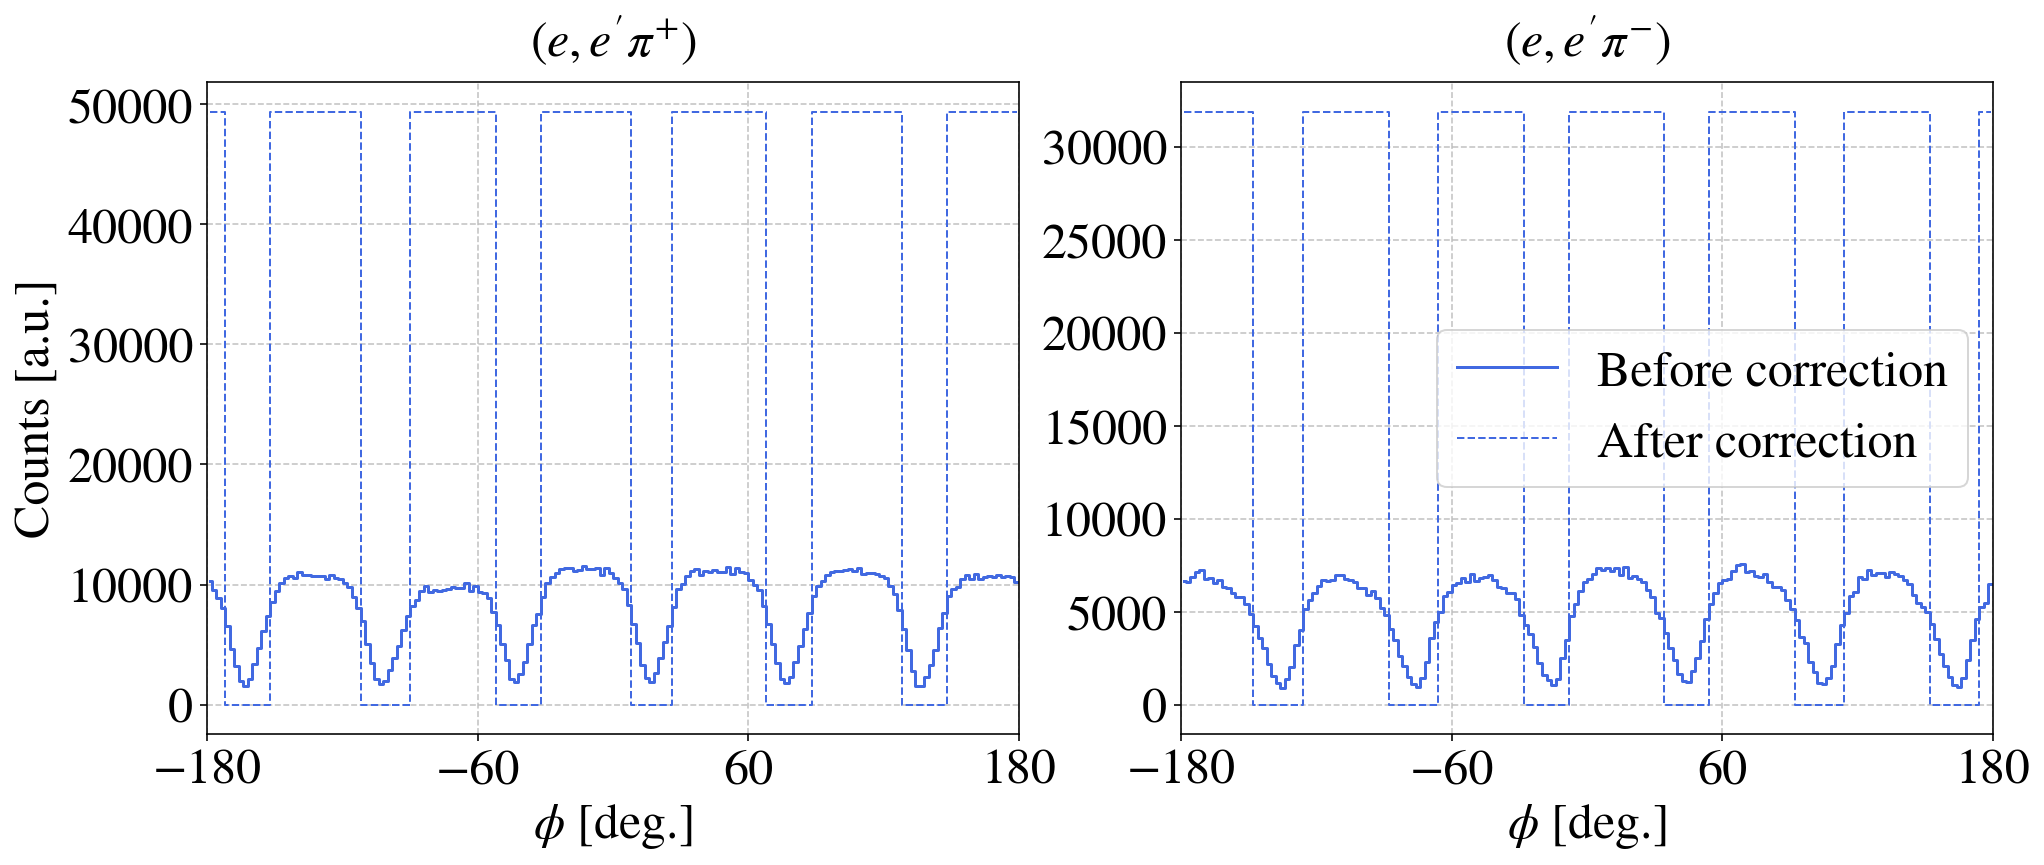

In [37]:
fig = plt.figure(figsize=(16,6));
    
for pi_ch,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_labels,pi_colors,[1,2]):#{
    ax = fig.add_subplot(1,2,pi_idx)

    df  = e_e_pi_pass_cuts[pi_ch];
    for run,color in zip([6422],['royalblue']):
        df_run = df[df.runnum==run]
        phi_run = np.array(df_run.pi_Phi)*r2d   
        
        # first plot - data with no acceptance correction
        x,histo,x_err,histo_err = plot_step_hist( x_arr=phi_run,  bins=phi_bins , label='Before correction', 
                                                   color=color,                    
                                                   do_plot_errorbar=False, density=False, linewidth=3)
        h['data-%d'%run]     = histo
        h_err['data-%d'%run] = histo_err
        # second plot - data from run 6421 with acceptance correction computed from run 6420
        h['data-%d corrected'%run]     = h['data-%d'%run] * AccCorrec[pi_ch];
        h_err['data-%d corrected'%run] = h_err['data-%d'%run] * AccCorrec[pi_ch];
        plt.step( phi_centers, h['data-%d corrected'%run] , '--', where='mid',
                 color=color, linewidth=1, label='After correction')


    # cosmetics
    set_axes(ax, '$\phi$ [deg.]', 'Counts [a.u.]' if pi_idx==1 else '',
                 title="$(e,e'"+pi_label+')$',
                 do_add_grid=True,
                 remove_ticks_y=False,
                 do_add_legend=True if pi_idx==2 else False,
                 xlim=phi_xlim,
                 xticks=phi_xticks)   

# (3) Check acceptance correction on other runs 6420,6422,6426 - $\phi_\pi$ distribution

### Data from other runs

In [38]:
# normalize by accumulated run beam charge
runs             = [6421,6422,6426] # 6420,
run_beam_charges = [495296,470705,408736] # 536118, #charge measured by c12.getRunBeamCharge(), not sure in which units
run_colors       = ['royalblue','salmon','k'] # ,'forestgreen'

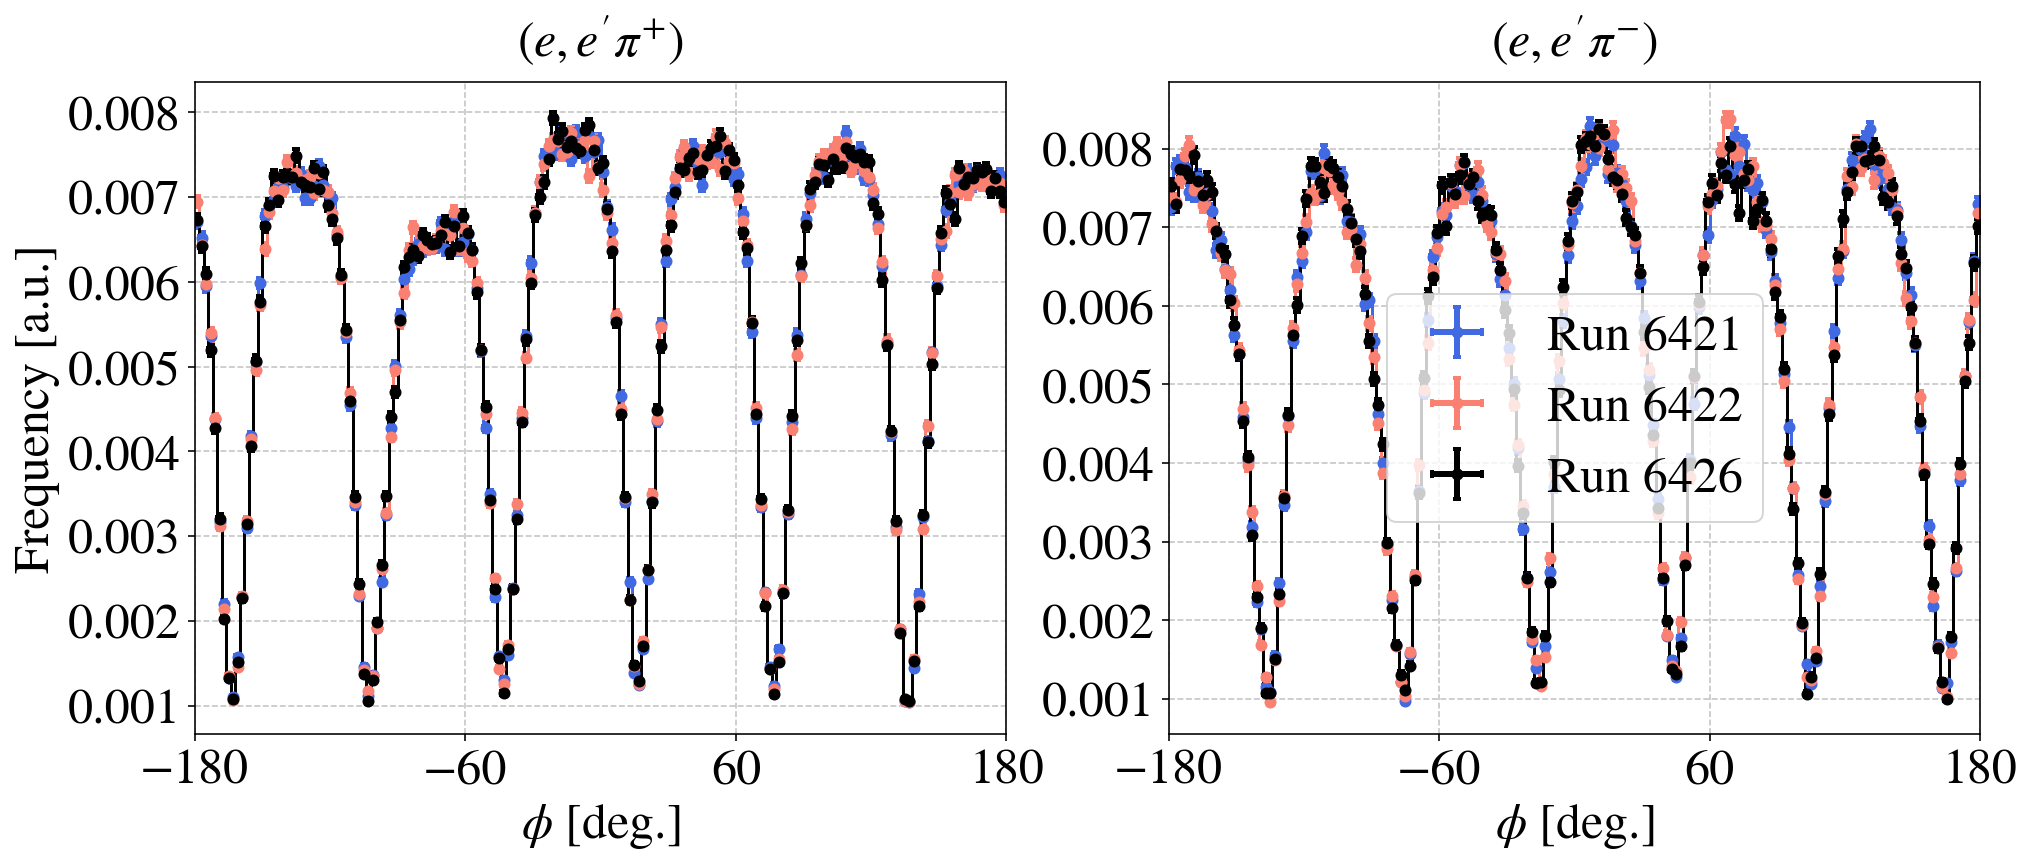

In [39]:
fig = plt.figure(figsize=(16,6));
    
for pi_ch,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_labels,pi_colors,[1,2]):#{
    ax = fig.add_subplot(1,2,pi_idx)
    
    df  = e_e_pi_pass_cuts[pi_ch];
    for run,run_beam_charge,color in zip(runs,run_beam_charges,run_colors):
        df_run = df[df.runnum==run]
        phi_run = np.array(df_run.pi_Phi)*r2d    
        plot_step_hist( x_arr=phi_run,  bins=phi_bins , label='Run %d'%run, 
                        color=color,
                        do_plot_errorbar=True, density=True, linewidth=3)
    
    # cosmetics
    set_axes(ax, '$\phi$ [deg.]', 'Frequency [a.u.]' if pi_idx==1 else '',
                 title="$(e,e'"+pi_label+')$',
                 do_add_grid=True,
                 remove_ticks_y=False,
                 do_add_legend=True if pi_idx==2 else False,
                 xlim=phi_xlim,
                 xticks=phi_xticks)   

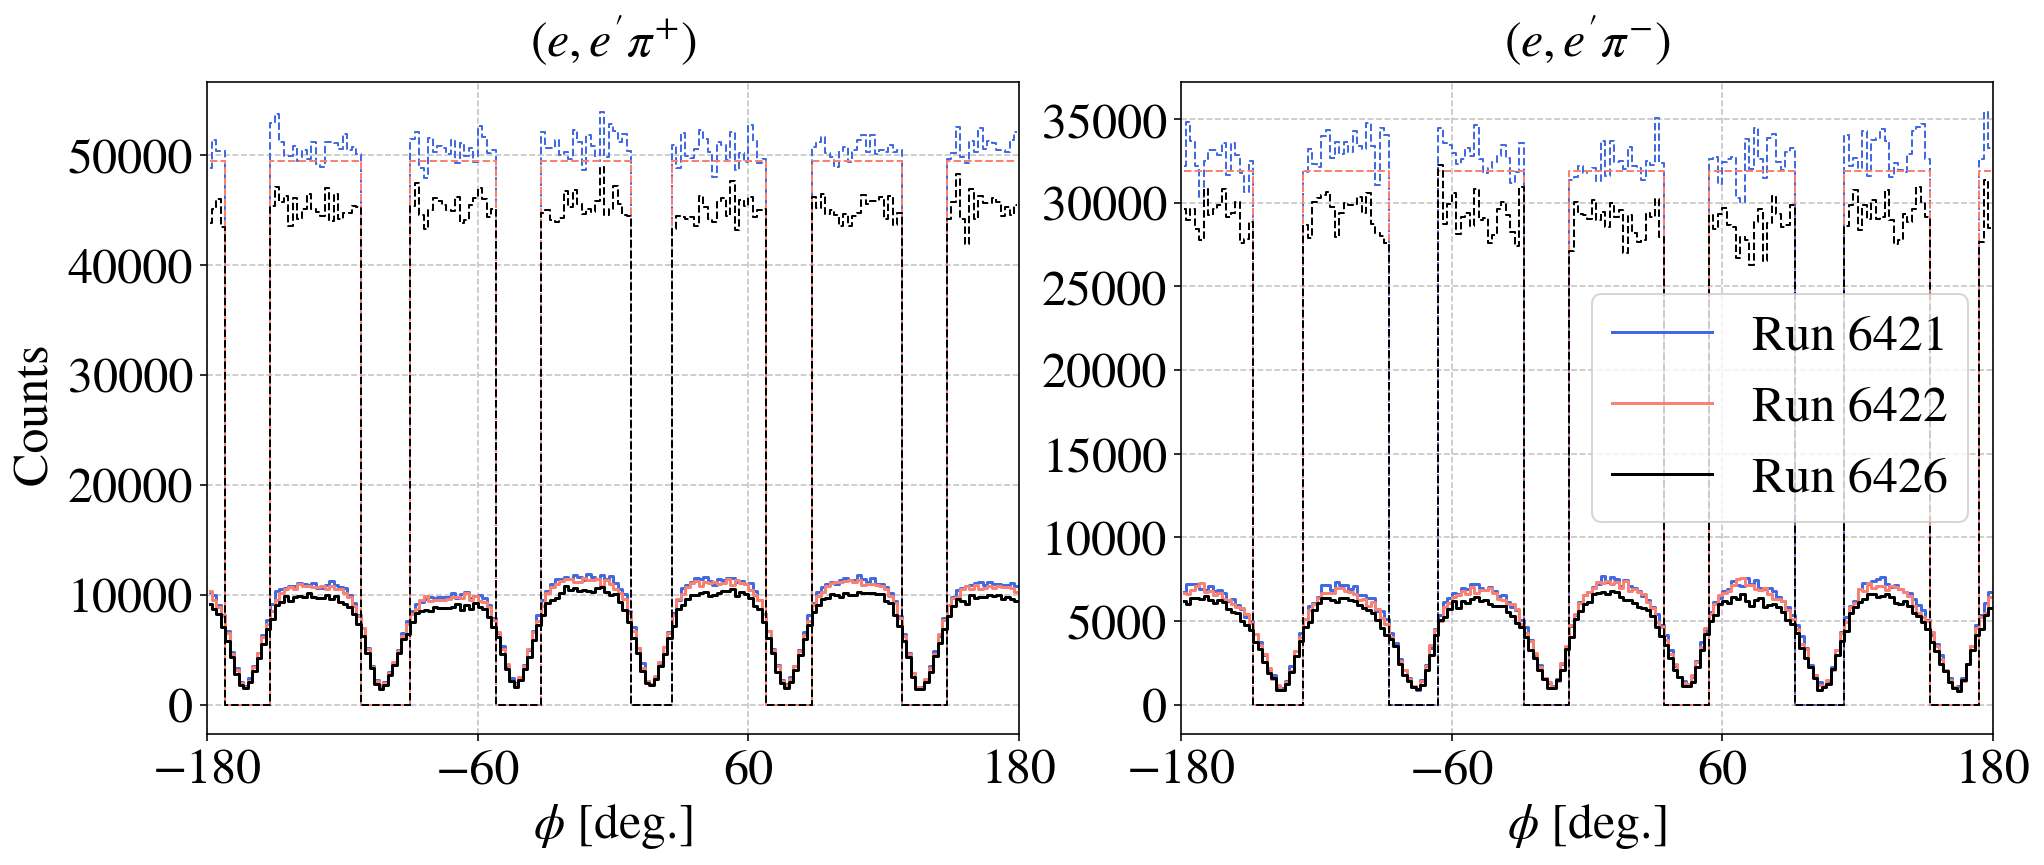

In [40]:
fig = plt.figure(figsize=(16,6));
    
for pi_ch,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_labels,pi_colors,[1,2]):#{
    ax = fig.add_subplot(1,2,pi_idx)

    df  = e_e_pi_pass_cuts[pi_ch];
    for run,run_beam_charge,color in zip(runs,run_beam_charges,run_colors):
        df_run = df[df.runnum==run]
        phi_run = np.array(df_run.pi_Phi)*r2d   
        
        # first plot - data with no acceptance correction
        x,histo,x_err,histo_err = plot_step_hist( x_arr=phi_run,  bins=phi_bins , label='Run %d'%run, 
                                                   color=color, 
                                                   do_plot_errorbar=False, density=False, linewidth=3)
        h[pi_ch+'data-%d'%run]     = histo
        h_err[pi_ch+'data-%d'%run] = histo_err
        # second plot - data from run 6421 with acceptance correction computed from run 6420
        h[pi_ch+'data-%d corrected'%run]     = h[pi_ch+'data-%d'%run]     * AccCorrec[pi_ch] ;
        h_err[pi_ch+'data-%d corrected'%run] = h_err[pi_ch+'data-%d'%run] * AccCorrec[pi_ch] ;
        
        # h[pi_ch+'data-%d corrected'%run]     = h[pi_ch+'data-%d corrected'%run]     * 1./run_beam_charge
        # h_err[pi_ch+'data-%d corrected'%run] = h_err[pi_ch+'data-%d corrected'%run] * 1./run_beam_charge

        plt.step( phi_centers, h[pi_ch+'data-%d corrected'%run], 
                 '--', where='mid',
                 color=color, linewidth=1)

    # cosmetics
    set_axes(ax, '$\phi$ [deg.]', 'Counts ' if pi_idx==1 else '',
                 title="$(e,e'"+pi_label+')$',
                 do_add_grid=True,
                 remove_ticks_y=False,
                 do_add_legend=True if pi_idx==2 else False,
                 xlim=phi_xlim,
                 xticks=phi_xticks)   

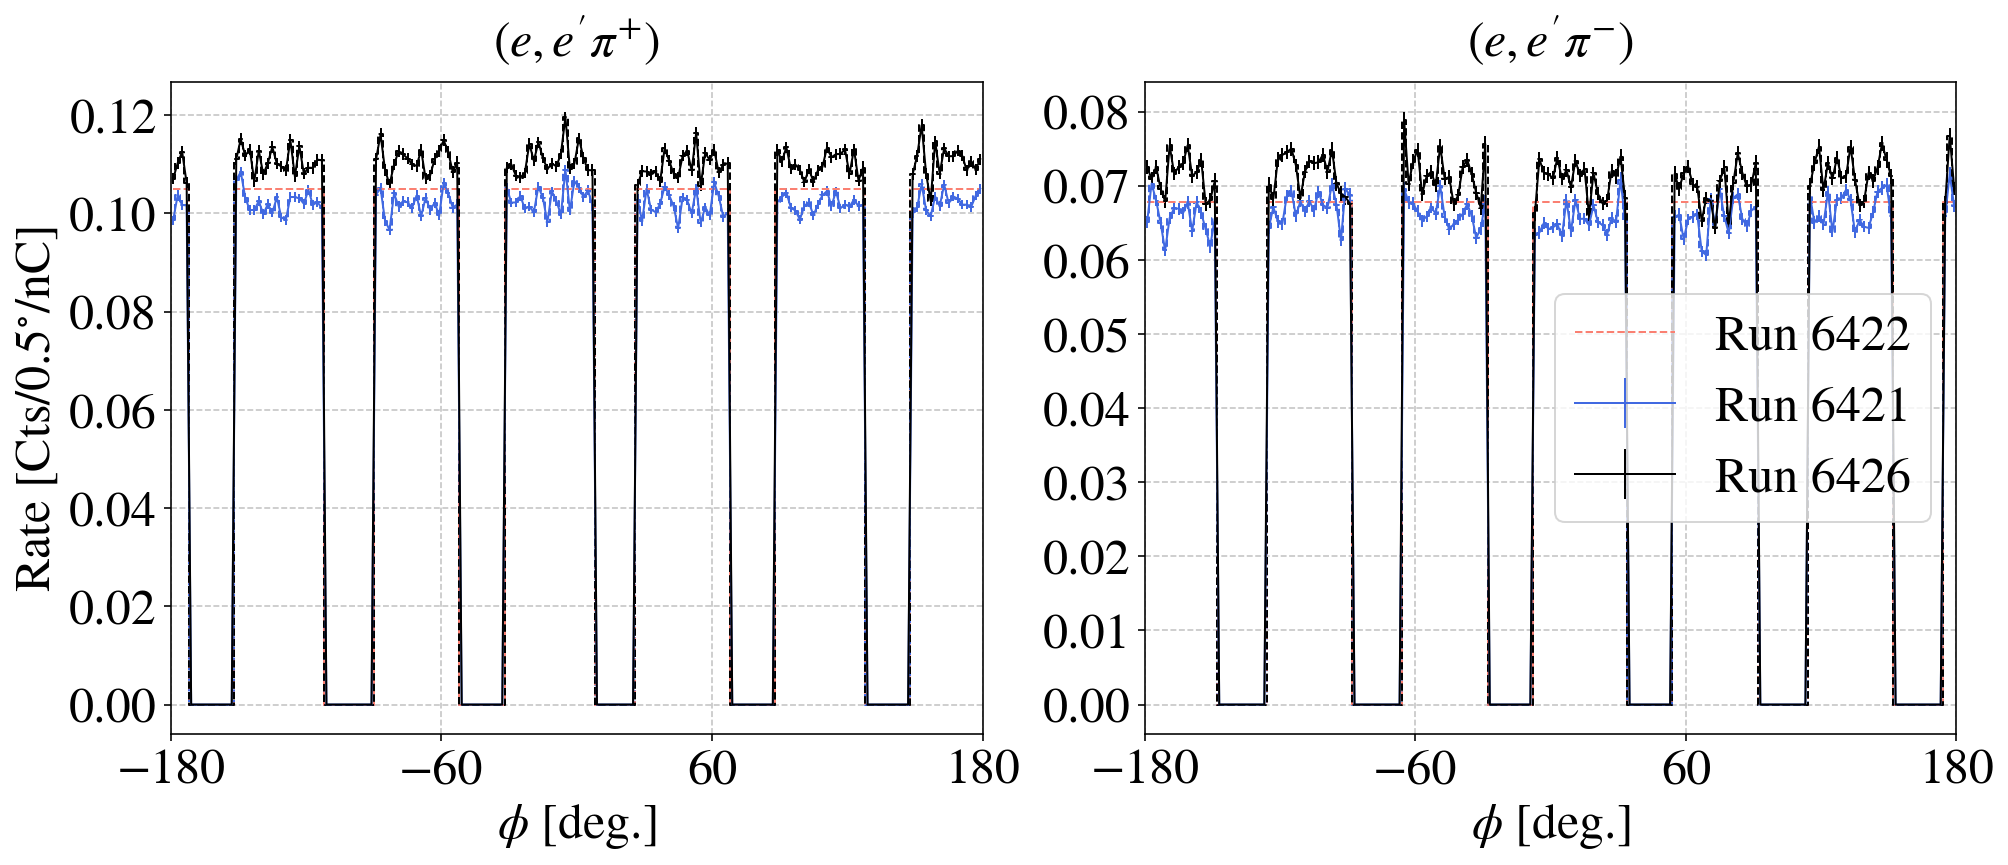

In [41]:
# normalize by beam charge
fig = plt.figure(figsize=(16,6));
    
for pi_ch,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_labels,pi_colors,[1,2]):#{
    ax = fig.add_subplot(1,2,pi_idx)
    for run,run_beam_charge,color in zip(runs,run_beam_charges,run_colors):
        scale = 1./run_beam_charge
        plt.step( phi_centers, 
                 h[pi_ch+'data-%d corrected'%run]*scale , 
                 '--', where='mid',    
                 label=None if run != 6422 else 'Run %d'%run,
                 color=color, linewidth=1)

        if run != 6422:
            plt.errorbar( phi_centers, 
                         h[pi_ch+'data-%d corrected'%run]*scale , 
                         h_err[pi_ch+'data-%d corrected'%run]*scale,
                         label='Run %d'%run,
                         color=color, linewidth=1)


    # cosmetics
    set_axes(ax, '$\phi$ [deg.]', 'Rate [Cts/$0.5^{\circ}$/nC]' if pi_idx==1 else '',
                 title="$(e,e'"+pi_label+')$',
                 do_add_grid=True,
                 remove_ticks_y=False,
                 do_add_legend=True if pi_idx==2 else False,
                 xlim=phi_xlim,
                 xticks=phi_xticks)   

# (4) Now check what happens to the (SIDIS) untagged cross-section ratio

In [42]:
z_bins          = [0.3,0.4,0.5,0.6,0.7,0.8,0.9]
z_width         = 0.01
var_e_e_pi      = 'xB'
xlabel_e_e_pi   = "Bjorken $x$"
x_bins          = np.linspace(0.2,0.6,10)
x_centers       = (x_bins[1:] + x_bins[:-1])/2
x_width         = (x_bins[1:] - x_bins[:-1])/2
fontsize        = 18

In [43]:
Rpips2pims, Rpips2pims_errup, Rpips2pims_errdw = dict(), dict(), dict()
for z_bin in z_bins:
    z_min,z_max = z_bin-z_width,z_bin+z_width
    weight_option = 'No Acc. correction'
    label = '%.1f %s'%(z_bin, weight_option)
    (Rpips2pims[label], 
     Rpips2pims_errup[label], 
     Rpips2pims_errdw[label]) = compute_ratio_pips_to_pims(df_dict=e_e_pi_pass_cuts ,                                                                            
                                                           var=var_e_e_pi, 
                                                           bins=x_bins,                                                            
                                                           z_min=z_min,z_max=z_max,
                                                           weight_option = weight_option)
    print('done z bin ',z_bin, 'with no acceptance correction');
    
    weight_option = 'Acc. correction as f(phi)'
    label = '%.1f %s'%(z_bin, weight_option)
    (Rpips2pims[label], 
     Rpips2pims_errup[label], 
     Rpips2pims_errdw[label]) = compute_ratio_pips_to_pims(df_dict=e_e_pi_pass_cuts ,                                                                            
                                                           var=var_e_e_pi, 
                                                           bins=x_bins,                                                            
                                                           z_min=z_min,z_max=z_max,
                                                           weight_option = weight_option)

    print('done z bin ',z_bin, 'with acceptance correction');
    # print(z_bin,Rpips2pims[z_bin],Rpips2pims_errup[z_bin],Rpips2pims_errdw[z_bin])
print('done') 

done z bin  0.3 with no acceptance correction
done z bin  0.3 with acceptance correction
done z bin  0.4 with no acceptance correction
done z bin  0.4 with acceptance correction
done z bin  0.5 with no acceptance correction
done z bin  0.5 with acceptance correction
done z bin  0.6 with no acceptance correction
done z bin  0.6 with acceptance correction
done z bin  0.7 with no acceptance correction
done z bin  0.7 with acceptance correction
done z bin  0.8 with no acceptance correction
done z bin  0.8 with acceptance correction
done z bin  0.9 with no acceptance correction
done z bin  0.9 with acceptance correction
done


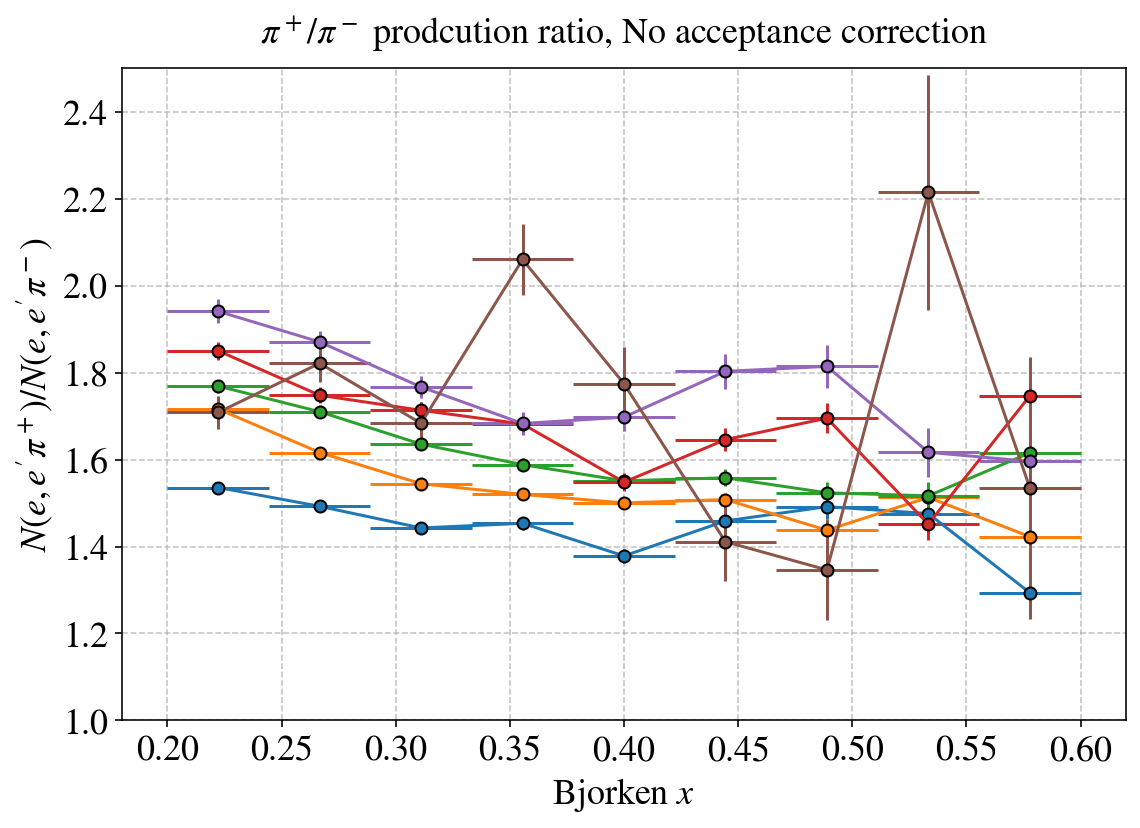

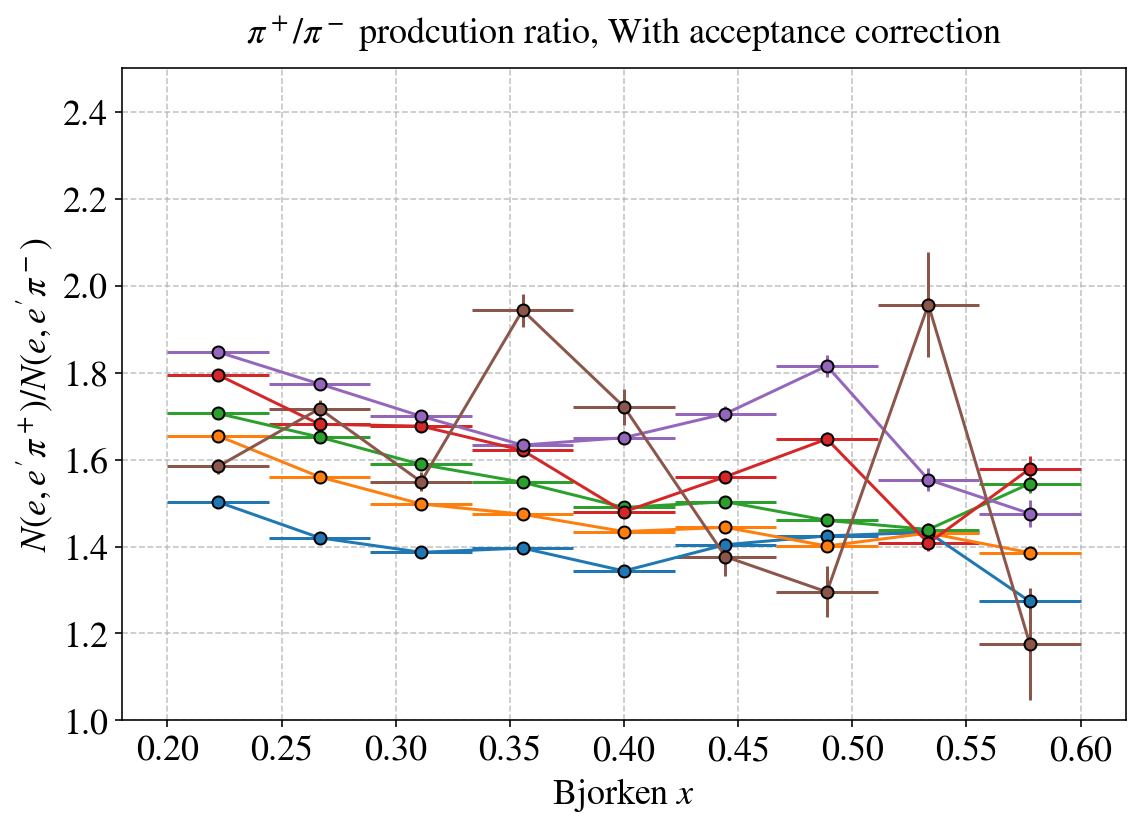

In [44]:
for weight_option,weight_label in zip(['No Acc. correction','Acc. correction as f(phi)'],
                                      ['No acceptance correction','With acceptance correction']):
    
    fig = plt.figure(figsize=(9,6))
    ax  = fig.add_subplot(1,1,1)
    for z_bin in z_bins:
        label = '%.1f %s'%(z_bin, weight_option)
        ax.errorbar(x=x_centers, xerr=x_width, 
                    y=Rpips2pims[label], yerr=(Rpips2pims_errup[label],Rpips2pims_errdw[label]),
                    marker='o',markeredgecolor='k',
                    label='$z=%.2f\pm%.2f$'%(z_bin,z_width))

    set_axes(ax,xlabel_e_e_pi,"$N(e,e'\pi^+)/N(e,e'\pi^-)$",
             title="$\pi^+/\pi^-$ prodcution ratio, "+weight_label,
             do_add_grid=True, do_add_legend=False, 
             fontsize=fontsize,
             ylim=(1,2.5));

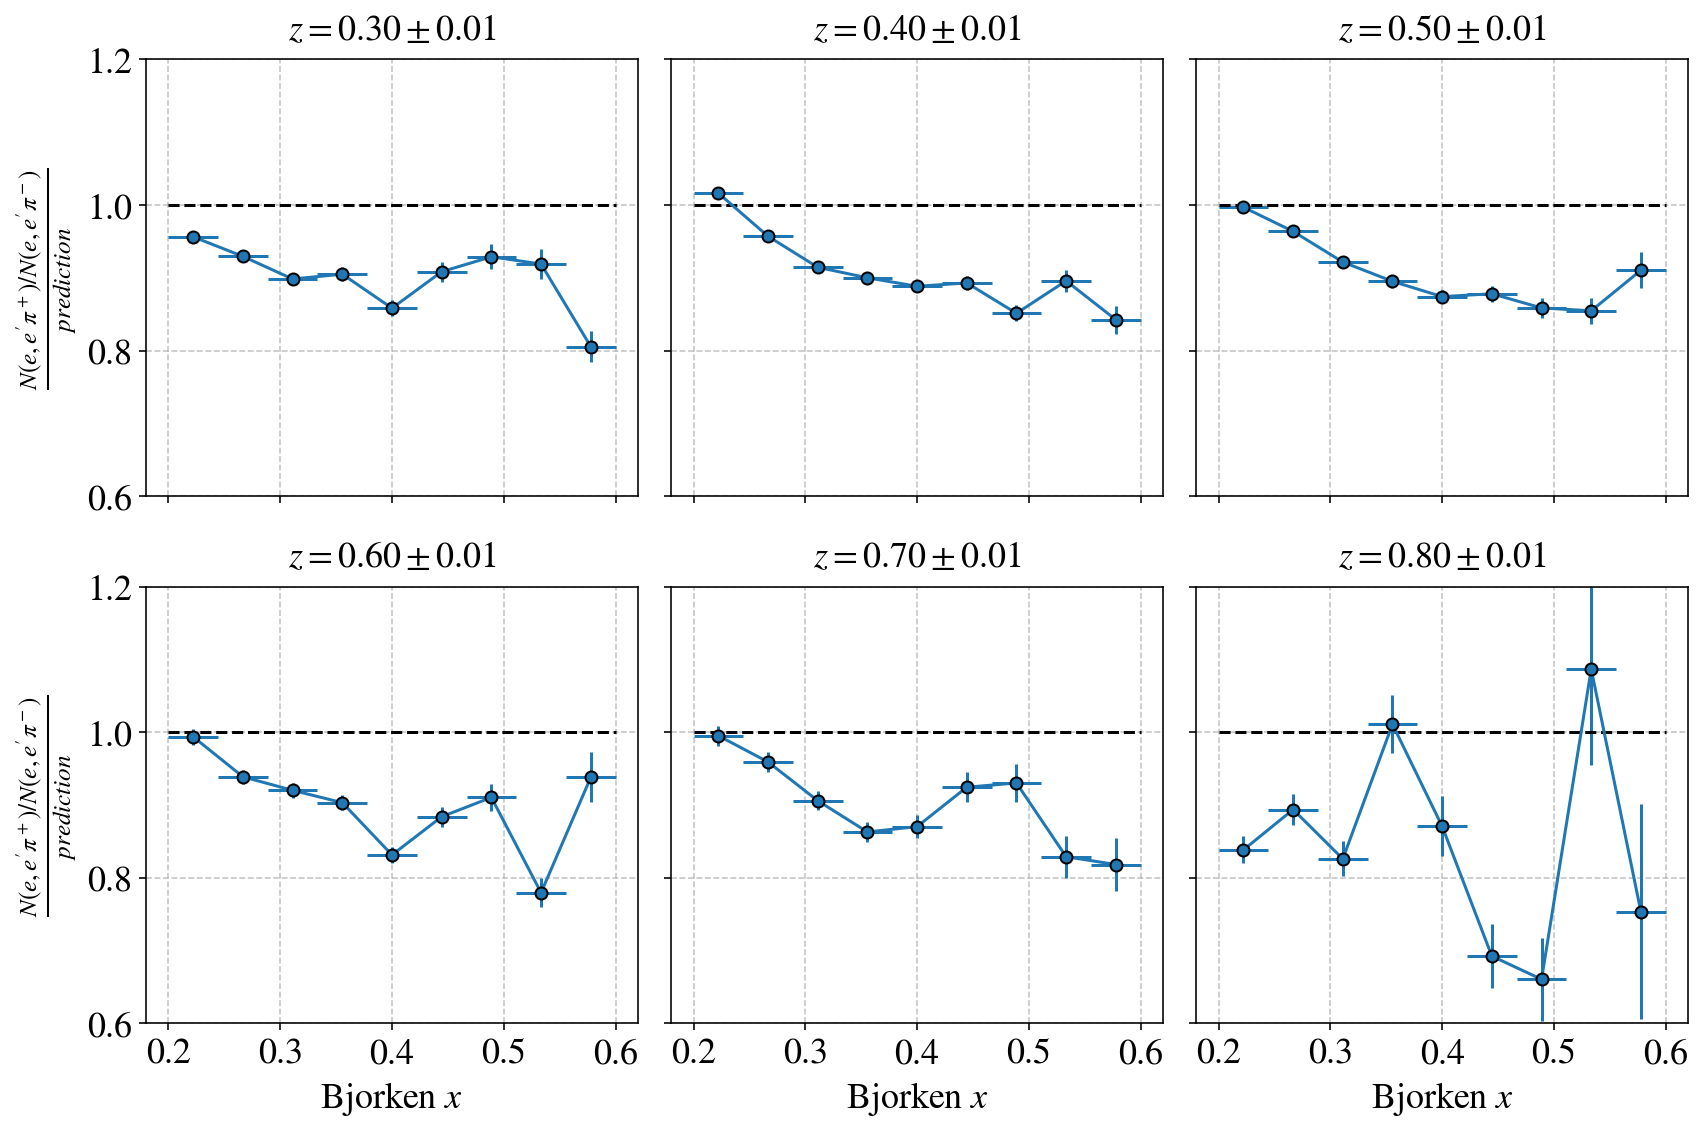

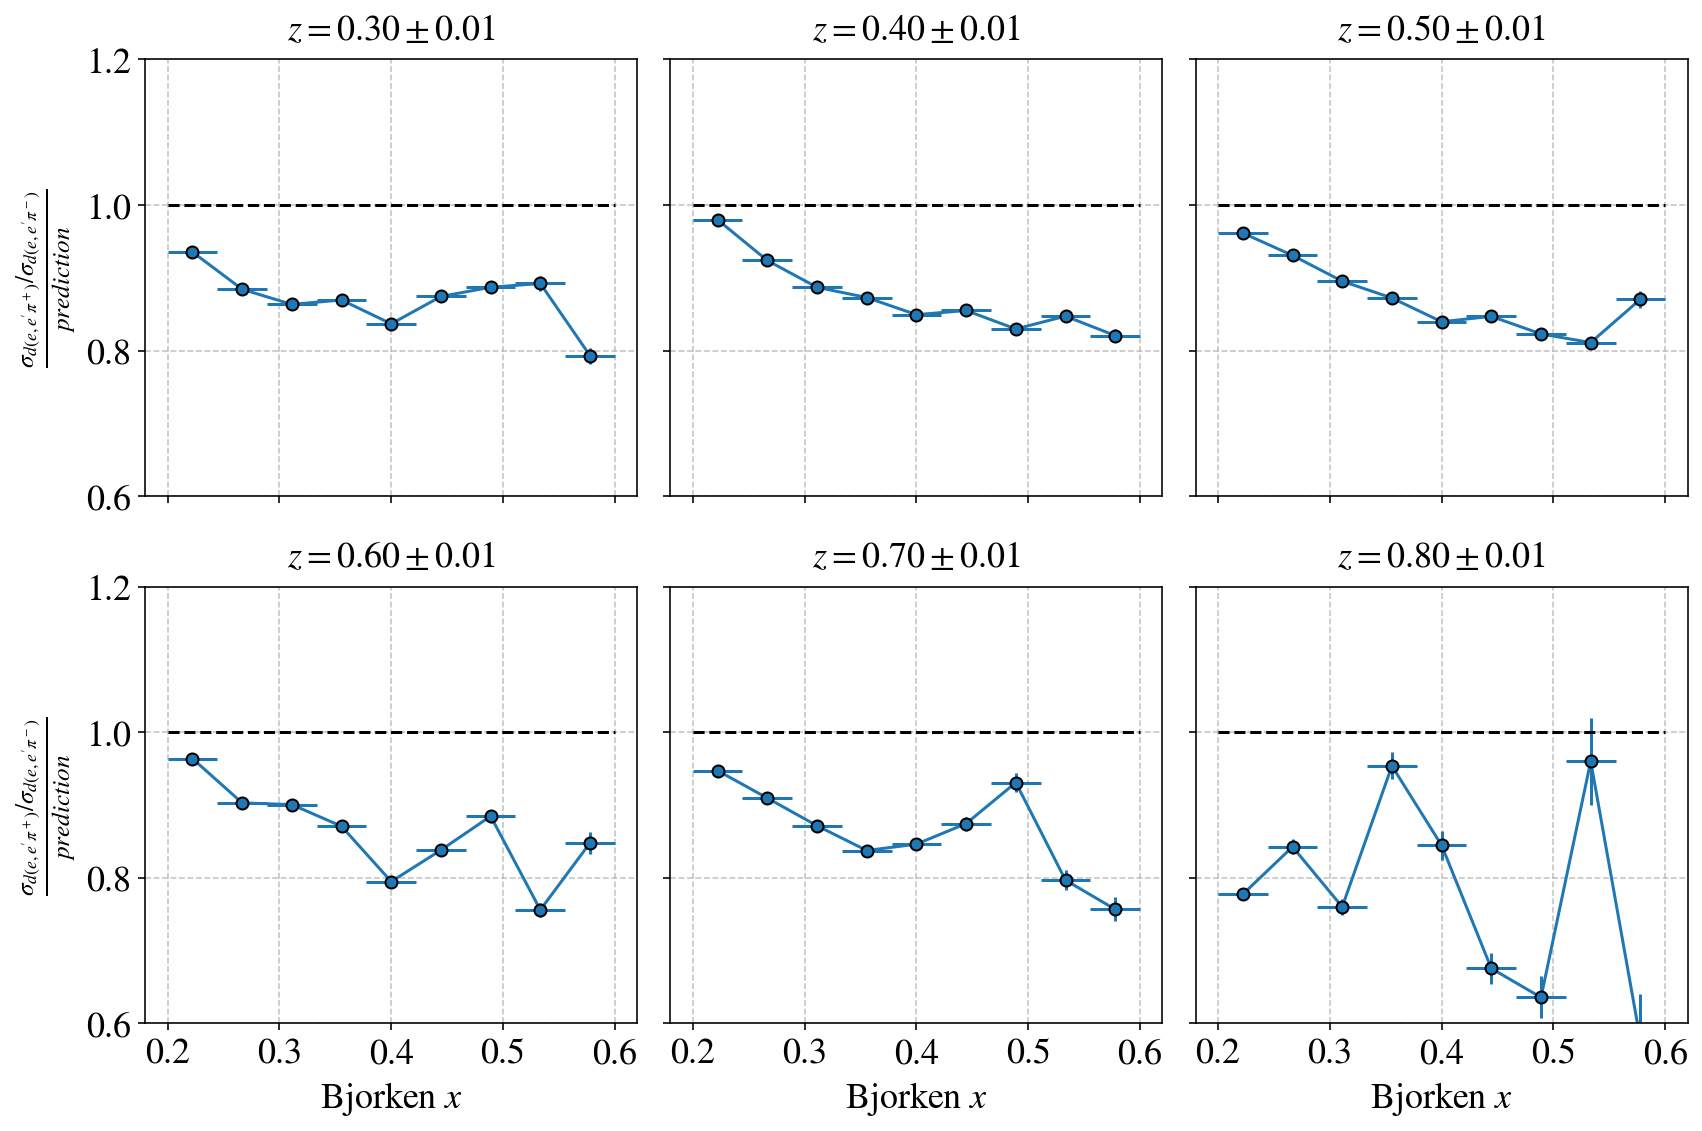

In [45]:
for (weight_option,weight_label,
     y_label) in zip(['No Acc. correction','Acc. correction as f(phi)'],                                      
                     ['No acceptance correction','With acceptance correction'],                   
                     ["$\\frac{N(e,e'\pi^+)/N(e,e'\pi^-)}{prediction}$",
                     "$\\frac{\sigma_{d(e,e'\pi^+)}/\sigma_{d(e,e'\pi^-)}}{prediction}$"]):

     
    fig = plt.figure(figsize=(12,8))
    for z_bin,subplot_idx in zip(z_bins[0:6],range(1,7)):
        label = '%.1f %s'%(z_bin, weight_option)
        ax = fig.add_subplot(2,3,subplot_idx)

        z = z_bin
        R_SIDIS = (4.58 + 0.16*z*z - 0.51*z)/(3.32 + 0.64*z*z - 2.04*z)
        ax.errorbar(x=x_centers, xerr=x_width, 
                    y = Rpips2pims[label]/R_SIDIS, 
                    yerr= (Rpips2pims_errup[label]/R_SIDIS, Rpips2pims_errdw[label]/R_SIDIS),
                    marker='o',markeredgecolor='k',
                    label='$z=%.2f\pm%.2f$'%(z_bin,z_width))
        ax.plot([0.2,0.6],[1,1],'--k')
        set_axes(ax,
                 x_label=xlabel_e_e_pi if subplot_idx>3 else '',
                 y_label=y_label if subplot_idx%3==1 else '',
                 remove_ticks_x=False if subplot_idx>3 else True,
                 remove_ticks_y=False if subplot_idx%3==1 else True,
                 title="$z=%.2f\pm%.2f$"%(z_bin,z_width),
                 do_add_grid=True, do_add_legend=False, fontsize=fontsize,
                 ylim=(0.6,1.2),yticks=(0.6,0.8,1,1.2));

    plt.tight_layout()